# Gradient Boosting (XGBoost) and Hyperparameter tuning using Python

##### This project is to demonstrate how to do cross validation to prevent over-fitting and then use Hyperparameter tuning to improve the prediction accuracy further

##### We will try and predict Customer Churn using XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read in the data
df = pd.read_csv(r'C:\Users\amitr\OneDrive\Desktop\Deep Learning\Data\Churn_Modelling.csv')
df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [3]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Basic data preprocessing 

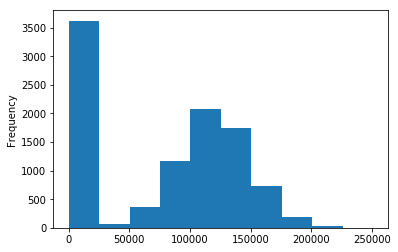

In [4]:
df['Balance'].plot(kind='hist')
plt.show()

In [5]:
# Let's create a new variable to capture if a person has any balance
df['Has_Balance'] = np.where(df['Balance'] > 0, 1, 0)
df['Has_Balance'].value_counts(normalize=True) * 100

1    63.83
0    36.17
Name: Has_Balance, dtype: float64

In [6]:
# Let's scale the relevant columns
from sklearn.preprocessing import StandardScaler

scaled_cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
sc = StandardScaler()

df_scaled_cols = sc.fit_transform(df[scaled_cols])

df_final = df.copy()
df_final[scaled_cols] = df_scaled_cols
df_final.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Has_Balance
0,-0.326221,France,Female,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,0
1,-0.440036,Spain,Female,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,1
2,-1.536794,France,Female,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,1
3,0.501521,France,Female,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,0
4,2.063884,Spain,Female,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,1


In [7]:
# One hot encoding
df_final = pd.get_dummies(df_final, drop_first=True)
df_final.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Has_Balance,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,0,0,0,0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,1,0,1,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,1,0,0,0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,0,0,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,1,0,1,0


In [8]:
# Split into train and test sets

from sklearn.model_selection import train_test_split

y = df_final['Exited']
X = df_final.drop('Exited', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

### Create a basic initial model using XGBoost

In [19]:
# Create a Decision Tree model

from xgboost import XGBClassifier

mod = XGBClassifier(random_state=0)
mod.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
# Predict the results

from sklearn.metrics import confusion_matrix, accuracy_score

pred_train = mod.predict(X_train)
pred_test = mod.predict(X_test)

# Check the accuracy
print("Training accuracy : ", accuracy_score(y_train, pred_train))
print("Testing accuracy : ", accuracy_score(y_test, pred_test))

Training accuracy :  0.87
Testing accuracy :  0.8652


C:\Users\amitr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\amitr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [17]:
# Let's prevent overfitting by using cross-validation
from sklearn.cross_validation import cross_val_score, KFold

k_fold = KFold(len(y_train), n_folds=10, random_state=0, shuffle=True)

avg = cross_val_score(mod, X_train, y_train, cv=k_fold, n_jobs=1)
print ('The accuracies on each fold are : ', avg)
print ("\nAverage accuracy on training set : ", avg.mean())


C:\Users\amitr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\amitr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\amitr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\amitr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

The accuracies on each fold are :  [0.87333333 0.86533333 0.852      0.856      0.86266667 0.86266667
 0.86666667 0.87333333 0.87466667 0.868     ]

Average accuracy on training set :  0.8654666666666667


C:\Users\amitr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Hyperparameter tuning

##### Let's do some hyperparameter tuning to see if we can improve it further

In [14]:
# Using GridSearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Set the hyperparameter values
parameters = [{'learning_rate':[0.01,0.05,0.1,0.2, 0.3, 0.5, 1.0],
              'max_depth':[3,4,5,6,10],
              'min_child_weight':[1,2,3]}]
    
mod = XGBClassifier()

grid_search = GridSearchCV(estimator=mod,
                           param_grid=parameters, 
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the training data for the models
grid_search = grid_search.fit(X_train, y_train)

In [15]:
# Display the best score and the optimal parameters

print ("Best accuracy : ", grid_search.best_score_)
print ("\n\nBest parameters : ", grid_search.best_params_)

Best accuracy :  0.8644


Best parameters :  {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3}


In [16]:
# Display the results on the test set

pred_y = grid_search.predict(X_test)

print ('Confusion Matrix : \n', confusion_matrix(y_test,pred_y))
print ('\n Test set accuracy : ', accuracy_score(y_test, pred_y))

Confusion Matrix : 
 [[1900   91]
 [ 245  264]]

 Test set accuracy :  0.8656


C:\Users\amitr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


##### There is not much difference in the accuracy on the test set.That is because XGBoost by default choose excelent parameters and so hyperparameter tuning did little to improve it further. Anyways, it's an excellent machine learning algorithm.